In [64]:
#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema
#import scipy as sp
from scipy.signal import find_peaks
import peakutils

In [65]:
#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_09_21_Myometrial_Contractility_Study_11_MB_1_8.tsv


In [66]:
#import data from excel reference file
#import muscle bath tsv file (as pandas dataframe?)
#import corresponding comments file
df_file = pd.read_csv(filename, sep='\t')
df_ref = pd.read_csv(ref_filename, sep='\t')
comments_file = open(comments_filename,'r')
df_ref.head()

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),...,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37
0,NaN,1,1,1,NaN,1.0,0.1,Adiponectin,100.0,21.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,1,2,NaN,0.0,0.0,Adiponectin,100.0,25.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1,1,3,NaN,1.0,0.1,Adiponectin,1000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1,1,4,NaN,0.0,0.0,Adiponectin,1000.0,24.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,1,5,NaN,1.0,0.1,TNF_alpha,0.1,29.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])

In [68]:
#drop unneccessary columns
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#view first 5 rows of input file
df_file.head()

,Comments,Force1,Force2,Force3,Force4,Force5,Force6,Force7,Force8
Experiment Time,,,,,,,,,
0.0,NaN,6.825,3.535,5.131,2.428,9.462,2.979,-0.05828,2.582
1.0,NaN,6.820,3.527,5.136,2.433,9.459,2.991,-0.04980,2.569
2.0,NaN,6.814,3.529,5.144,2.436,9.483,2.992,-0.05404,2.582
3.0,NaN,6.816,3.532,5.129,2.430,9.477,2.997,-0.04980,2.578
4.0,NaN,6.814,3.530,5.136,2.436,9.451,2.995,-0.05616,2.577


In [69]:
df_ref
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#view processed input file
df_ref.head()

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
112,2018_09_21_Myometrial_Contractility_Study_11_M...,11,AC12,3,NaN,0.0,0.00,Omentin,500.0,23.52,1.91,1.65,52.0,NaN
113,2018_09_21_Myometrial_Contractility_Study_11_M...,11,AC12,4,NaN,1.0,0.05,Control,NaN,19.15,2.12,1.39,42.0,NaN
114,2018_09_21_Myometrial_Contractility_Study_11_M...,11,AC12,5,NaN,0.0,0.00,Resistin,500.0,20.26,1.84,1.86,44.0,NaN
115,2018_09_21_Myometrial_Contractility_Study_11_M...,11,AC12,6,NaN,1.0,0.05,Resistin,500.0,19.17,1.80,1.64,28.0,NaN
117,2018_09_21_Myometrial_Contractility_Study_11_M...,11,AC12,8,NaN,1.0,0.05,Adiponectin,100.0,24.66,1.43,1.26,23.0,NaN


In [102]:
df_ref.reset_index(drop=True)
df_ref
len(df_ref)
#list([pd.Index(range(len(df_ref)))])

df_ref.set_index([pd.Index(list(range(len(df_ref))))])



<class 'numpy.int64'>


In [70]:
#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(input("What time does baseline end"))
    baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[(bath)-1]])
    baseline_array_list.append(baseline_array)

Pitocin : 7434.4
Baseline : 11304.7
Treatment Bath 1 : 15284.1
Treatment Bath 3 : 15343.5
Treatment Bath 4 : 15368.6
Treatment Bath 5 : 15413.5
Treatment Bath 6 : 15521.4
Treatment Bath 8 : 15525.5
Muscle Bath 3 :
What time does baseline end15343
Muscle Bath 4 :
What time does baseline end15368
Muscle Bath 5 :
What time does baseline end15413
Muscle Bath 6 :
What time does baseline end15521
Muscle Bath 8 :
What time does baseline end15525


Muscle Bath 3


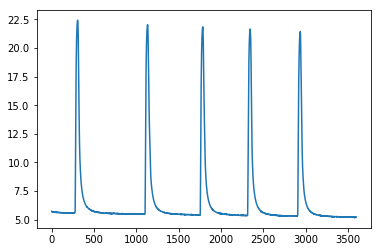

patientAC12_bath3.pdf
Muscle Bath 4


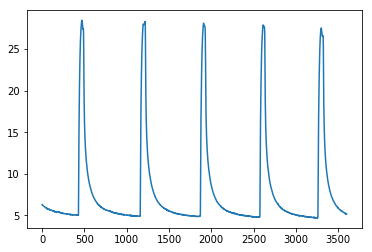

patientAC12_bath4.pdf
Muscle Bath 5


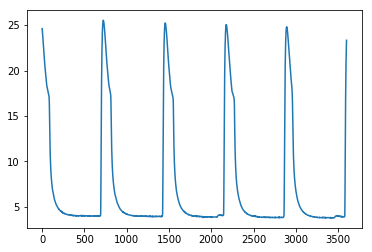

patientAC12_bath5.pdf
Muscle Bath 6


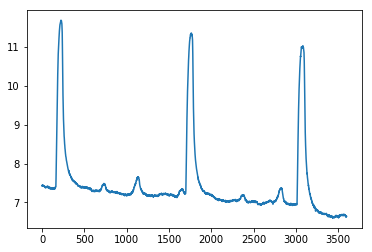

patientAC12_bath6.pdf
Muscle Bath 8


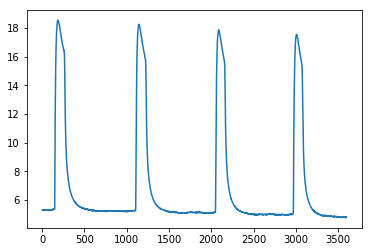

patientAC12_bath8.pdf


In [105]:
#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath)
    f = plt.figure()
    #plt.plot(np.array(baseline_array_list[bath-1]))
    plt.plot(np.array(baseline_array_list[i-1]))
    plt.show()
    #savestring = "patient"+(list(df_ref['Patient'])[bath-1])+"_"+"bath"+str(bath)+'.pdf'
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [109]:
#loop through baths in reference dataframe 
    #for each bath listed in the reference file, find the max/min(local extreme) for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr

#find local max values
#input the height cut off for peak analysis
locmax_list = []
fp_output_list = []
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
#for bath in df_ref['Bath Number']:
    print("Muscle Bath",bath,":")
    cutoff = float(input("input peak height cutoff:"))
    #fp_output = find_peaks(np.array(baseline_array_list[(bath-1)]),height = cutoff, width = 35)
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = 35)
    #locmax = np.array(baseline_array_list[(bath-1)])[fp_output[0]]
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)

Muscle Bath 3 :
input peak height cutoff:15
Muscle Bath 4 :
input peak height cutoff:20
Muscle Bath 5 :
input peak height cutoff:20
Muscle Bath 6 :
input peak height cutoff:10
Muscle Bath 8 :
input peak height cutoff:10


In [110]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

In [111]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
#startlist = []
#create an empty list to store end indices
#endlist = []
#create an empty list to store an arrays of baseline values
#base_val_list = []
#loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
#store values in startlist and endlist
#for peak_time in locmax_indx_list[0]:
#    starttime = peak_time-105
#    endtime = peak_time-45
#    if starttime < 0:
#        starttime = 0
    #if endtime < 0:
    #    break
#    startlist.append(starttime)
#    endlist.append(endtime)
#loop through contractions, calculate baseline values, assign values to spot in base_val_list
#for i in range(len(startlist)):
#    baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[startlist[i]:endlist[i]])
#    base_val_list.append(baseline_values)
#plot muscle baths with local min baseline and local max values highlighted     
#plt.plot(np.array(baseline_array_list[0]))  
#for counter, base_data in enumerate(base_val_list):
#    plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
#for counter, peak in enumerate(locmax_list[0]):
#    plt.plot(locmax_indx_list[0][counter],peak,'ro')
    #plt.plot(locmax_indx_list[0][0],locmax_list[0][0],'ro')
#plt.show()

#arr = []
#for base_val in base_val_list:
#        arr.append(base_val.mean())
#arr = np.array(arr)
#print(arr)


In [112]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
#startlist = []
#create an empty list to store end indices
#endlist = []
#create an empty list to store an arrays of baseline values
#base_val_list = []
#create an empty list to store baseline means
#base_mean_list = []
#loop through muscle baths
#for bath in df_ref['Bath Number']:
    #reset lists
    #startlist = []
    #endlist = []
    #base_val_list = []
    #base_mean_list = []
    #print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    #for peak_time in locmax_indx_list[0]:
    #    starttime = peak_time-105
    #    endtime = peak_time-45
    #    if starttime < 0:
    #        starttime = 0
        #if endtime < 0:
        #    break
    #    startlist.append(starttime)
    #    endlist.append(endtime)
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    #for i in range(len(startlist)):
    #    baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[startlist[i]:endlist[i]])
    #    base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    #plt.plot(np.array(baseline_array_list[0]))  
    #for counter, base_data in enumerate(base_val_list):
    #    plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
    #for counter, peak in enumerate(locmax_list[0]):
    #    plt.plot(locmax_indx_list[0][counter],peak,'ro')
    #plt.show()
    #for base_val in base_val_list:
    #    base_mean_list.append(base_val.mean())
    #    base_mean_array = np.array(base_mean_list)
    #print(base_mean_array)
locmax_indx_list

[array([ 469, 1216, 1909, 2613, 3300], dtype=int64),
 array([ 723, 1456, 2177, 2892], dtype=int64),
 array([], dtype=int64),
 array([ 185, 1144, 2086, 3008], dtype=int64),
 array([ 306, 1133, 1785, 2345, 2938], dtype=int64)]

Muscle Bath 3


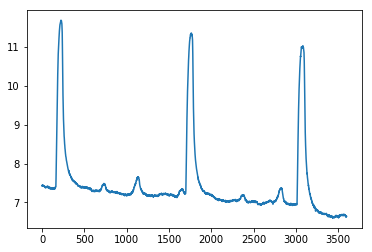

peakanalysisgraphs_patientAC12_bath3.pdf
mean baseline force: [13.3415182  13.28707068 13.20001856 13.1568662 ]
Muscle Bath 4


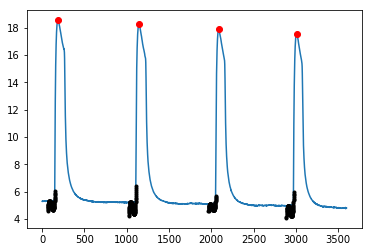

peakanalysisgraphs_patientAC12_bath4.pdf
mean baseline force: [4.59284262 4.22706838 4.56272508 4.08820753]
Muscle Bath 5


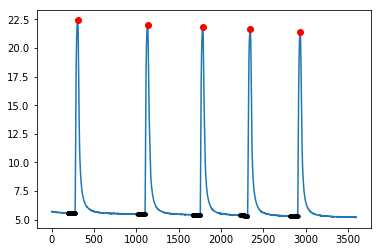

peakanalysisgraphs_patientAC12_bath5.pdf
mean baseline force: [5.56880211 5.47911821 5.41441316 5.35498501 5.31709112]
Muscle Bath 6


IndexError: list index out of range

In [113]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
startlist = []
#create an empty list to store end indices
endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#create an empty list to temporarily store baseline means
templist = []
#create an empty list to append array of baseline means
base = []
#loop through muscle baths
for bath in df_ref['Bath Number']:
    #reset lists
    startlist = []
    endlist = []
    base_val_list = []
    templist = []
    print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    for peak_time in locmax_indx_list[bath-1]:
        #vary start time and peak time in order to find proper baseline local min
        #starttime = peak_time-110
        #starttime = peak_time-180
        #starttime = peak_time-90
        starttime = peak_time - 120
        #starttime = peak_time-240
        #endtime = peak_time-80
        #endtime = peak_time-90
        endtime = peak_time-60
        #endtime = peak_time-210
        endtime = peak_time-30
        if starttime < 0:
            starttime = 0
        if endtime < 0:
            endtime = 2
        startlist.append(starttime)
        endlist.append(endtime)
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    for i in range(len(startlist)):
        baseline_values = peakutils.baseline(np.array(baseline_array_list[bath-1])[startlist[i]:endlist[i]])
        base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    f = plt.figure()

    plt.plot(np.array(baseline_array_list[bath-1])) 
    
    
    for counter, base_data in enumerate(base_val_list):
        plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'k.')
    for counter, peak in enumerate(locmax_list[bath-1]):
        plt.plot(locmax_indx_list[bath-1][counter],peak,'ro')
    
    plt.show()
    
    savestring = "peakanalysisgraphs_" + "patient"+(list(df_ref['Patient'])[bath-1])+"_"+"bath"+str(bath)+'.pdf'
    
    print(savestring)
    f.savefig(savestring,sep = '')
    
    
    
    #average local min baseline data
    for base_val in base_val_list:
        #altered code to calculate the minimum value of baseline instead of average*******
        #templist.append(base_val.mean())
        templist.append(base_val.min())
        base_mean_array = np.array(templist)
    print("mean baseline force:",base_mean_array)
    #store local min baseline data in list
    base.append(base_mean_array)

In [61]:
#calculate baseline peak forces
for mb in range(len(locmax_list)):
    print ("bath",mb+1,"force (g)")
    for i in range(len(locmax_list[mb])):
        print(locmax_list[mb][i]-base[mb][i])

bath 1 force (g)
26.62373760872198
26.78062948929546
27.029530439287363
27.362512041555433
27.817634150929077
bath 2 force (g)
17.552570342037413
17.60718997263207
17.779027188388913
18.089138664786507
18.240606039089492
18.25375250468453
17.884207249052174
bath 3 force (g)
11.914025977549475
11.77811485534999
12.337968662806627
11.783842337747263
11.106904963157245
bath 4 force (g)
6.821295869464893
6.835258377455006
6.563036890003259
7.123648649661541
8.582856547260409
6.727484440395781
8.001739866813828
6.658071774239073
7.771713162834318
bath 5 force (g)
3.3636204907270653
4.362805973947039
5.600403520956249
4.8115219497686095
5.096397750901868
5.424045153786216
bath 6 force (g)
2.1233567319715494
2.124212095679292
6.775998518513369
4.4964317671153164
2.1492227787795883
2.17001927255256
6.522597837517578
2.2101423826968265
2.3982603210695768
6.620988658967537
0.8326268523642231
0.8269767358976221
7.056938856896245
2.108321603553046
2.1883693087845426
7.191094809241237
7.19901930376

In [62]:
#calculate CSA
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])
    CSA = (length *1.056)/mass
    CSA_list.append(CSA)
#for i in range(len(CSA_list)):
#    print("Muscle Bath", i + 1)
#    print(CSA_list[i])

In [63]:
#calculate CSA normalized baseline peak forces
for mb in range(len(locmax_list)):
    print ("bath",mb+1,"norm (g/CSA)")
    for i in range(len(locmax_list[mb])):
        print((locmax_list[mb][i]-base[mb][i])/CSA_list[mb])

bath 1 norm (g/CSA)
84.96548167515705
85.46617749780066
86.26050583051898
87.32316437386355
88.77561518344773
bath 2 norm (g/CSA)
21.213434283779012
21.279445695307107
21.487122258507377
21.861912348905182
22.044970620616972
22.060858987877715
21.614239271079622
bath 3 norm (g/CSA)
35.67261911089488
35.2656781067127
36.941975579021275
35.28282716265796
33.25596158663999
bath 4 norm (g/CSA)
13.675646066443573
13.70363874131455
13.15787664781912
14.281816754286634
17.207303513225124
13.48756862111835
16.04225420336174
13.348406932041549
15.581086142387257
bath 5 norm (g/CSA)
4.5596578195857065
5.914134019959811
7.59179692761467
6.522404576512878
6.908576612813928
7.352728991700655
bath 6 norm (g/CSA)
5.854380347914363
5.856738700802283
18.682340073609936
12.397267673762919
5.925696520948846
5.983035253822508
17.98368028430904
6.093660069704338
6.612326549489399
18.25495702402906
2.2956643168954876
2.2800861852007803
19.456930405606567
5.812926474895143
6.033628773923244
19.82681642576437

In [43]:
CSA_force = []

for mb in range(len(locmax_list)):
    temps_list = []
    #print ("MUSCLE BATH",mb+1)
    for i in range(len(locmax_list[mb])):
        temps_list.append((locmax_list[mb][i]-base[mb][i])/CSA_list[mb])
    CSA_force.append(np.array(temps_list))
counter = 0    
for bath in df_ref['Bath Number']:
#for forces in CSA_force:
    print ("bath",bath," mean\n",CSA_force[counter].mean(),'\n',"bath",bath," std\n",CSA_force[counter].std(),'\n',sep = '')
    counter+=1

bath1 mean
69.56049644218103
bath1 std
1.133553062411977

bath2 mean
75.06185845140905
bath2 std
1.5689466734958921

bath3 mean
77.8859983880273
bath3 std
0.010261488944287578

bath4 mean
29.104411974201167
bath4 std
4.157290156875933

bath5 mean
44.22872561357451
bath5 std
0.7276046747920222

bath6 mean
3.84311500594051
bath6 std
0.22569064510083728

bath7 mean
9.41369141941908
bath7 std
0.15006539624643622

bath8 mean
21.59442771523092
bath8 std
0.20577647389237622



In [44]:

#print(peak_list[0])
#print(peak_list[0].mean())
#print(peak_list[0].std())

#print(peak_idx_list[0][0])
    


In [45]:
#find the baseline force/minimum value before each peak

#x = argrelextrema(np.array(baseline_array_list[0]), np.less,order=100)
#print(np.array(baseline_array_list[0])[x])
#print(x)
#print(peak_idx_list[0][0])
#np.amin(np.array(baseline_array_list[0][0:500]))
#print(np.array(baseline_array_list[0])[0:500])



#baseline_values = peakutils.baseline(np.array(baseline_array_list[0])[500:1000])

#print(baseline_values)



In [46]:
#gradients=np.diff(np.array(baseline_array_list[0]))
#print(np.argmax(gradients))
#np.array(baseline_array_list[0])[2309]

#subtract minimum value from peak force to calculate amplitude of contraction
#calculate mean value of contraction amplitude
#calculate standard deviation
#calculate contractions amplitude corrected to CSA
#calculate mean value of contractions amplitude/CSA
#calculate standard deviation of contractions amplitude/CSA


#from max/min calculate the amplitudes/peaks
#calculate the average for each bath
#calculate the peaks 

#loop through baths and find peak forces
#input function to determine when baseline period should be

In [ ]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [297]:
#calculate duration/ relaxation time
peaks = find_peaks(np.array(baseline_array_list[0]),height = 10, width = 30)
print(peaks)
print(peaks[1])

(array([ 371, 1017, 1676, 2331, 3003], dtype=int64), {'peak_heights': array([22.71, 22.33, 22.73, 22.45, 22.39]), 'prominences': array([19.013, 18.67 , 19.133, 18.857, 18.8  ]), 'left_bases': array([ 104,  757, 1511, 2061, 2773], dtype=int64), 'right_bases': array([1511, 1511, 3419, 3419, 3419], dtype=int64), 'widths': array([73.36527039, 75.12037037, 75.5745694 , 76.40619883, 78.65058712]), 'width_heights': array([13.2035, 12.995 , 13.1635, 13.0215, 12.99  ]), 'left_ips': array([ 353.30035461,  998.12962963, 1657.12304965, 2312.11222222,
       2984.2189781 ]), 'right_ips': array([ 426.665625  , 1073.25      , 1732.69761905, 2388.51842105,
       3062.86956522])})
{'peak_heights': array([22.71, 22.33, 22.73, 22.45, 22.39]), 'prominences': array([19.013, 18.67 , 19.133, 18.857, 18.8  ]), 'left_bases': array([ 104,  757, 1511, 2061, 2773], dtype=int64), 'right_bases': array([1511, 1511, 3419, 3419, 3419], dtype=int64), 'widths': array([73.36527039, 75.12037037, 75.5745694 , 76.40619883,

In [302]:
peaks[1]['left_bases']

array([ 104,  757, 1511, 2061, 2773], dtype=int64)

In [47]:
comments_file.close()